<a href="https://colab.research.google.com/github/cszafariqbal/cszafar/blob/master/Image-CNN-Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Question NO.1 By using CNN

In [1]:
!pip install opendatasets

In [3]:
import pandas as pd
import numpy as np
import opendatasets as od

In [4]:
url = "https://www.kaggle.com/datasets/cashutosh/gender-classification-dataset"
od.download(url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: zeeooma
Your Kaggle Key: ··········


100%|██████████| 269M/269M [00:15<00:00, 18.2MB/s]


In [23]:
dir = "./gender-classification-dataset"

In [24]:
import os
os.listdir(dir)

['Training', 'Validation']

In [ ]:
# female_path = "/content/gender-classification-dataset/Training/female"
# male_path = "/content/gender-classification-dataset/Training/male"

In [25]:
folder_path = "./gender-classification-dataset/Training"

In [27]:
file_list = os.listdir(folder_path)
file_list

['male', 'female']

In [28]:
for cls in file_list:
  print(cls, ':', len(os.listdir(folder_path  + "/" + cls)))

male : 23766
female : 23243


In [48]:
import torch
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import figure
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
dataset = ImageFolder(folder_path, transform = tt.Compose([tt.Resize(255), tt.RandomCrop(224), tt.ToTensor()]))

In [31]:
dataset

Dataset ImageFolder
    Number of datapoints: 47009
    Root location: ./gender-classification-dataset/Training
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=warn)
               RandomCrop(size=(224, 224), padding=None)
               ToTensor()
           )

In [40]:
dataset.classes

['female', 'male']

In [41]:
dataset.class_to_idx

{'female': 0, 'male': 1}

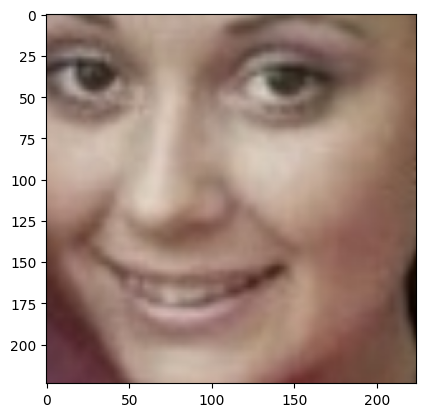

In [32]:
image, label = dataset[14]
plt.imshow(image.permute(1,2,0))

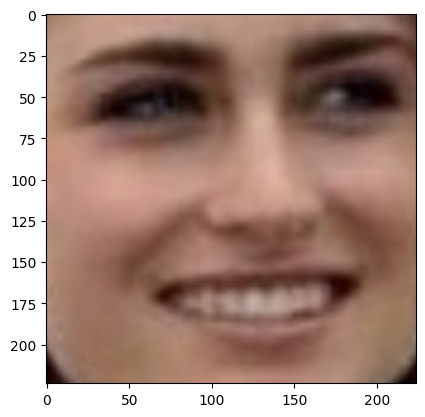

In [33]:
image, label = dataset[34]
plt.imshow(image.permute(1,2,0))

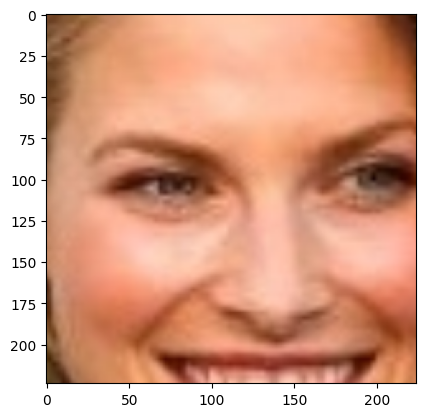

In [34]:
image, label = dataset[1444]
plt.imshow(image.permute(1,2,0))

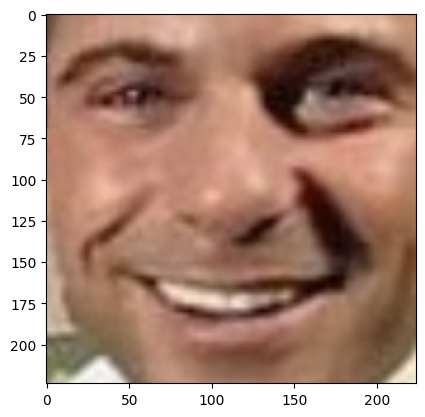

In [35]:
image, label = dataset[34000]
plt.imshow(image.permute(1,2,0))

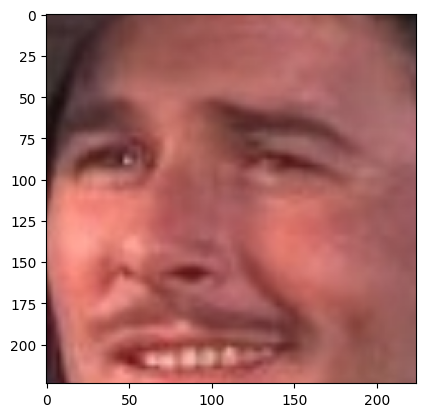

In [36]:
image, label = dataset[38037]
plt.imshow(image.permute(1,2,0))

In [37]:
size_per = 0.2
valid_size = int(len(dataset) * size_per)
train_size = len(dataset) - valid_size

In [38]:
print(train_size, valid_size)

37608 9401


In [39]:
train_ds, valid_ds = random_split(dataset, [train_size, valid_size])
len(train_ds), len(valid_ds)

(37608, 9401)

In [42]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [43]:
def show_batch(dl):
  for image, _ in dl:
    px, ax = plt.subplots(figsize=(16,12))
    ax.set_xticks([]), ax.set_yticks([])
    ax.imshow(make_grid(image, nrow=16).permute(1,2,0))
    torch.cuda.empty_cache
    break


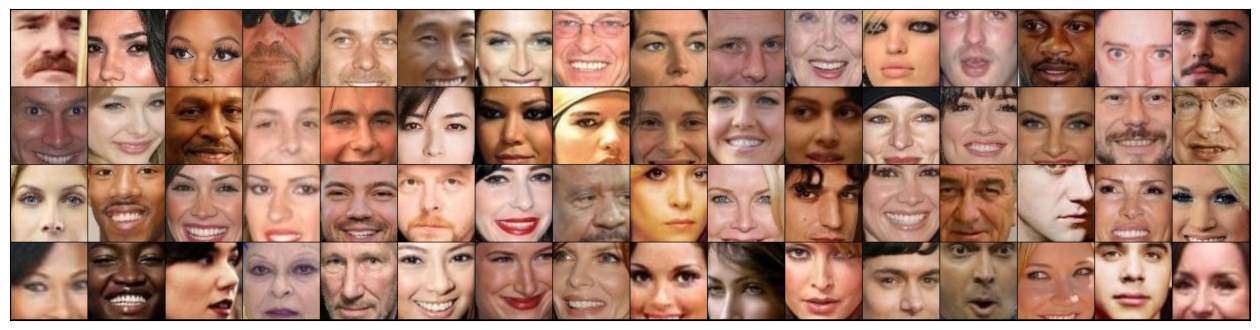

In [44]:
show_batch(train_dl)

In [45]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [46]:
device = get_default_device()
device

device(type='cuda')

In [47]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [52]:
class MaleFemale(nn.Module):
    """ calculate the loss of batch of training dataloader"""
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        torch.cuda.empty_cache
        return loss
    """calculate the loss and accuracy of batch of validation dataloader"""
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)
        torch.cuda.empty_cache          # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))


In [53]:
class CNN(MaleFemale):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # conv1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            # conv2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            # conv3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            # conv4
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
        )

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(50176, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, K),
        )

    def forward(self, X):
        out = self.conv_layers(X)

        # Flatten
        out = out.view(-1, 50176)

        # Fully connected
        out = self.dense_layers(out)

        return out

In [54]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

@torch.no_grad()
def evaluate(model, val_loader):
    """ Define the model's performance on validation set..."""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            torch.cuda.empty_cache
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            torch.cuda.empty_cache
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        torch.cuda.empty_cache
    return history

In [55]:
model = to_device(CNN(len(dataset.classes)), device)
model

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [56]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[{'val_loss': 0.6935368776321411, 'val_acc': 0.48964300751686096}]

In [57]:
%%time
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.5614, val_loss: 0.4401, val_acc: 0.8101
Epoch [1], train_loss: 0.2619, val_loss: 0.2591, val_acc: 0.8908
Epoch [2], train_loss: 0.2213, val_loss: 0.4587, val_acc: 0.8554
Epoch [3], train_loss: 0.1994, val_loss: 0.1529, val_acc: 0.9435
Epoch [4], train_loss: 0.1894, val_loss: 0.2235, val_acc: 0.9107
CPU times: user 8min 26s, sys: 8min 30s, total: 16min 57s
Wall time: 19min 44s


In [58]:
%%time
history += fit(1, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.1338, val_loss: 0.1144, val_acc: 0.9603
CPU times: user 1min 42s, sys: 1min 43s, total: 3min 25s
Wall time: 3min 56s


In [59]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

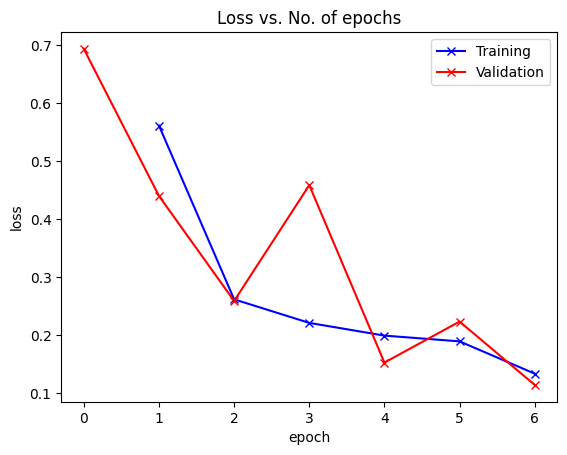

In [60]:
plot_losses(history)

In [61]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [62]:
def show_image_prediction(img, label):
  plt.imshow(img.permute(1, 2, 0))
  print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: female , Predicted: female


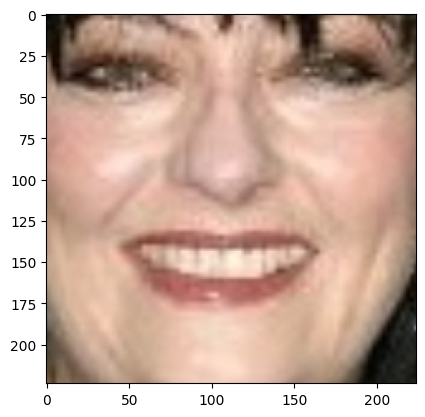

In [63]:
show_image_prediction(*valid_ds[257])

Label: male , Predicted: male


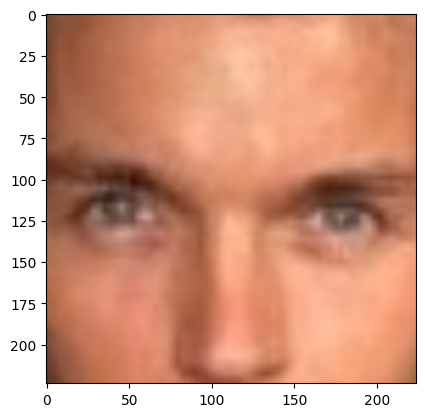

In [64]:
show_image_prediction(*valid_ds[2257])

Label: male , Predicted: male


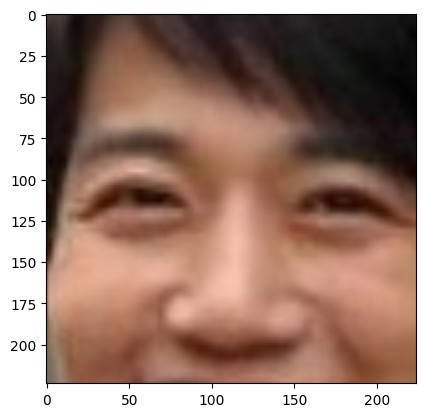

In [65]:
show_image_prediction(*valid_ds[1257])

Label: male , Predicted: male


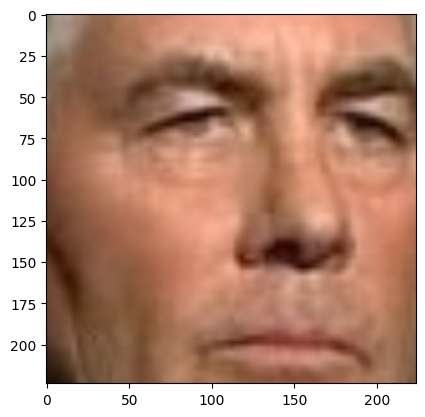

In [66]:
show_image_prediction(*valid_ds[6667])